# Maximum Likelihood Estimation

Let's say I have some data, and I want to modify a function so that it fits to the data as closely as possible. Scratch that. I want to *maximize the likelihood* the function would generate the data I am observing. This is exactly what **maximum likelihood estimation** is, where we find the joint probability a given function would output some observed data. This technique is used to fit probability distributions to a given dataset, as well as train machine learning algorithms like linear regression and logistic regression. 

We will learn about maximum likelihood estimation by applying it first to a normal distribution. We will then extend that framework to fit a linear regression. Of course, a linear regression can be fit using least squares, but as we will learn maximum likelihood estimation will arrive at a nearly identical solution. Given that linear regression is the workhorse and building block of machine learning, this will tie ideas of how probability plays a role in machine learning. 

## Fitting a Normal Distribution

Let's observe some measurements from a machining process at a shop, and plot it on a number line. 

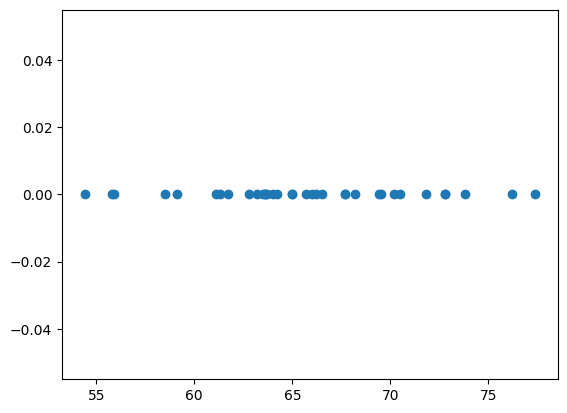

In [8]:
import numpy as np 
import matplotlib.pyplot as plt

X = np.array([54.4,55.8,55.9,58.5,59.1,61.1,61.3,61.7,62.8,
              63.2,63.5,63.6,63.6,63.7,64.0,64.2,65.0,65.0,
              65.7,66.0,66.2,66.5,67.7,67.7,68.2,69.4,69.5,
              70.2,70.5,71.8,72.8,72.8,73.8,76.2,77.4])

plt.plot(X, [0 for _ in X], 'o')
plt.show()

We suspect that this data follows a normal distribution and want to fit one to it. While we could simply take the mean and standard deviation of the data, and then use them in our parameters for a normal distribution, let's take a more probabilistic approach with maximum likelihood estimation. Other distributions like the exponential distribution would have to take that approach, and so would fitting a linear regression or logistic regression. 

We got a lot to break down. Let's first discussion the idea of joint likelihood for this purpose. Observe the datapoints and a given normal distribution below. 

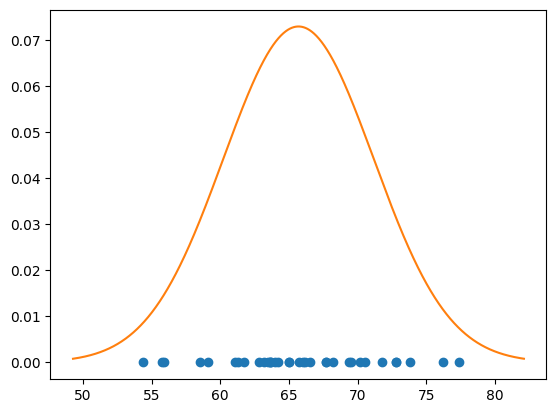

In [12]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

X = np.array([54.4,55.8,55.9,58.5,59.1,61.1,61.3,61.7,62.8,
              63.2,63.5,63.6,63.6,63.7,64.0,64.2,65.0,65.0,
              65.7,66.0,66.2,66.5,67.7,67.7,68.2,69.4,69.5,
              70.2,70.5,71.8,72.8,72.8,73.8,76.2,77.4])

mu, sigma = 65.696, 5.469

# plot the distribution and points
x_range = np.arange(start=-3 * sigma + mu, stop=3 * sigma + mu, step=.01)
plt.plot(X, [0 for _ in X], 'o')
plt.plot(x_range, norm.pdf(x_range, mu, sigma))
plt.show()

Imagine each of those points projecting themselves upward onto the curve, and the resulting y-values are the likelihoods. 

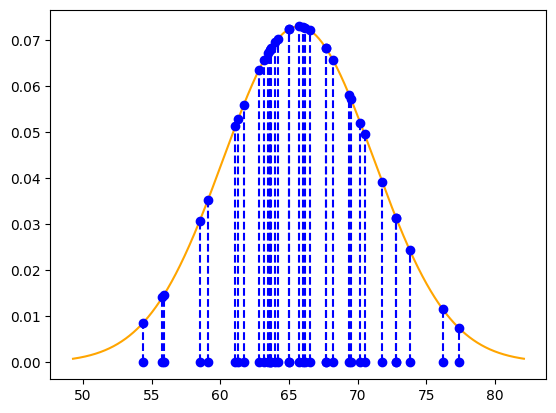

In [14]:
plt.plot(x_range, norm.pdf(x_range, mu, sigma), color='orange')

# plot lines
for x in X:
    plt.plot(np.array([x,x]),
              np.array([0, norm.pdf(x, mu, sigma)]),
             'bo', linestyle="--")

plt.show()

Those resulting y-values resembling the likelihoods are what we want to multiply together, called the **joint likelihood**. We can calculate this using the `prod()` function on a NumPy array. 

In [15]:
import numpy as np
from scipy.stats import norm

X = np.array([54.4,55.8,55.9,58.5,59.1,61.1,61.3,61.7,62.8,
              63.2,63.5,63.6,63.6,63.7,64.0,64.2,65.0,65.0,
              65.7,66.0,66.2,66.5,67.7,67.7,68.2,69.4,69.5,
              70.2,70.5,71.8,72.8,72.8,73.8,76.2,77.4])

mu, sigma = 65.696, 5.469

likelihoods = norm.pdf(X, mu, sigma)
joint_likelihood = norm.pdf(X, mu, sigma).prod()

print(f"Likelihoods: {likelihoods}")
print(f"\nJoint Likelihood: {joint_likelihood}")

Likelihoods: [0.00864221 0.01419127 0.01466621 0.03069447 0.03524832 0.05124446
 0.05280845 0.05585652 0.06340355 0.06573127 0.06729631 0.06778089
 0.06778089 0.06824614 0.06952152 0.07026743 0.07235779 0.07235779
 0.07294609 0.0728335  0.07263701 0.0721621  0.06820964 0.06820964
 0.06568733 0.0579959  0.05727254 0.05196669 0.04959663 0.03912929
 0.03137701 0.03137701 0.0243333  0.01153384 0.00738749]

Joint Likelihood: 3.8502714598977635e-48


This joint likelihood is likely to get very small as shown above, as we are multiplying a lot of probabilities together. Behind the scenes, summing log-likelihoods (instead of multiplication) are used to avoid floating point underflows but we will let NumPy do that work. The point is we want to adjust mu and sigma so we maximize that total joint likelihood (hence maximum likelihood estimation). 

To apply maximum likelihood estimation, we need to learn an optimization algorithm first. Normally we would use a technique like gradient descent or stochastic gradient descent. However, to prevent the need for a crash course in Calculus (another Anaconda course on that later!) we will use a simpler algorithm called hill climbing. **Hill climbing** allows us to use a random-based, but methodical, search that makes random adjustments to values but only accepts values that improve towards an objective. In this case, the objective is the maximum total joint likelihood. 

Recall a normal distribution accepts parameters *mu* $ \mu $ and *sigma* $ \sigma $. We will repeatedly make random adjustments to these two parameters and only accept adjustments that improve the total maximum likelhood. But what are the random adjustments going to be? We do not necessarily want to brute-force with uniformly random values, but we can sample from a standard normal distribution (with a mean of 0 and standard deviation of 1) so we can get mostly small adjustments near 0 but occasional large adjustments in the tail. Observe the standard normal distribution below. 

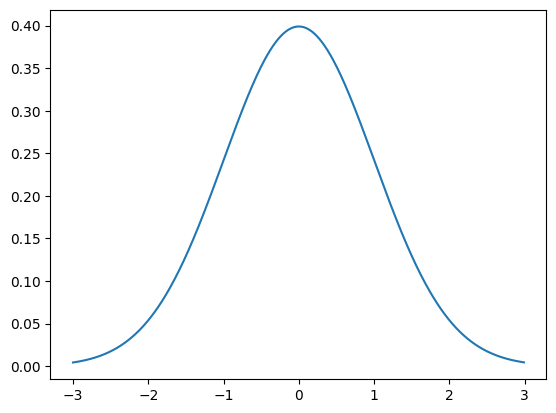

In [16]:
import matplotlib.pyplot as plt
from scipy.stats import norm

x_range = np.arange(start=-3, stop=3, step=.01)
plt.plot(x_range, norm.pdf(x_range, loc=0, scale=1))
plt.show()

It may seem pretty meta (and conceptually circuituous) that we use a normal distribution to randomly adjust another normal distribution. But it works! Remember that one is the normal distribution we are fitting to our data, and another normal distribution generates random adjustments to $ \mu $ and $ \sigma $. 

Let's put these concepts together and use hill climbing to execute maximum likelihood estimation. We will start $ \mu $ at one of the data points and the standard deviation at 1. They just roughly have to start somewhere near the points and then hill climbing will adjust them accordingly. 

mu,sigma -> 53.83603021825059, 2.486289699007811
mu,sigma -> 54.46510717147743, 2.6503451763329937
mu,sigma -> 54.297843019309354, 4.327018131379839
mu,sigma -> 56.01249398957389, 5.527950912751666
mu,sigma -> 55.885162226533346, 5.758945935337318
mu,sigma -> 56.46696919643975, 5.4558201902495504
mu,sigma -> 57.17088789743447, 6.204304324457523
mu,sigma -> 56.59896824252594, 7.1145063819928716
mu,sigma -> 56.47000003963374, 7.687243648693262
mu,sigma -> 56.944192655899236, 8.455402114641299
mu,sigma -> 57.3406995692788, 7.902179322267585
mu,sigma -> 57.83157062849265, 8.274947056750975
mu,sigma -> 58.699323005261284, 7.875312903320612
mu,sigma -> 59.56944208931823, 6.682189378066738
mu,sigma -> 59.95631938190428, 7.930530915107863
mu,sigma -> 60.96370185782551, 9.662259031927551
mu,sigma -> 61.53244964598667, 9.72901741512955
mu,sigma -> 61.56593810512531, 8.464005550099655
mu,sigma -> 61.69508795839711, 7.8736576860004615
mu,sigma -> 62.01905106198167, 8.316229172081872
mu,sigma -> 63

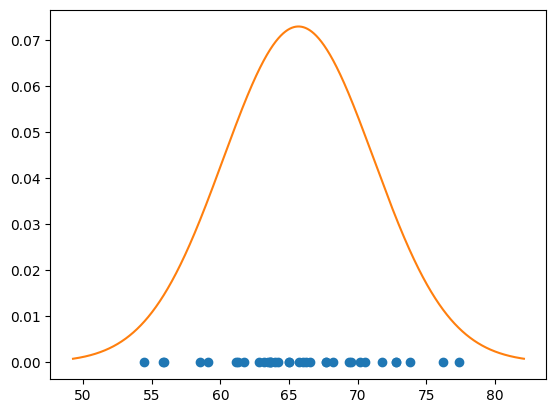

In [18]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# declare X datapoints 
X = np.array([54.4,55.8,55.9,58.5,59.1,61.1,61.3,61.7,62.8,
              63.2,63.5,63.6,63.6,63.7,64.0,64.2,65.0,65.0,
              65.7,66.0,66.2,66.5,67.7,67.7,68.2,69.4,69.5,
              70.2,70.5,71.8,72.8,72.8,73.8,76.2,77.4])

# start mean at the first data point, and sigma at 1
# does not matter where they start, they should just be 
# somewhere inside or close to the dataset 
mu, sigma = X[0], 1

# generates a random value from a standard normal distribution
# where mean is 0, and standard deviation is 1 
def random_adj(): return np.random.normal(loc=0, scale=1, size=1)[0]

# start best joint likelihood at 0
best_joint_likelihood = 0

# do 10,000 random adjustments to mu and sigma 
for i in range(10_000):

    # randomly adjust mu and sigma 
    mu_adj, sigma_adj = random_adj(), random_adj()

    mu += mu_adj
    sigma += sigma_adj

    # calculate the new joint likelihood of all data points 
    new_joint_likelihood = norm.pdf(X, mu, sigma).prod()

    # if joint likelihood improves, keep the changes to mu and sigma 
    if new_joint_likelihood > best_joint_likelihood:
        best_joint_likelihood = new_joint_likelihood
        print(f"mu,sigma -> {mu}, {sigma}")
    else:
        # otherwise undo changes 
        mu -= mu_adj
        sigma -= sigma_adj

# plot the result 
x_range = np.arange(start=-3 * sigma + mu, stop=3 * sigma + mu, step=.01)

plt.plot(X, [0 for _ in X], 'o')
plt.plot(x_range, norm.pdf(x_range, mu, sigma))

plt.show()

Based on the print outputs and the plot above, you can see the curve moved effectively to fit to the points. Notice too that if we take the mean and standard devation of the data, it matches what the maximum likelihood estimation found. 

In [20]:
X.mean(), X.std()

(65.68, 5.475963059460083)

This was not just a needless academic exercise though. You can fit any probability distribution given data using this technique. 

Now let's extend this idea to fitting a linear regression.

## Using MLE to Fit a Linear Regression

Next let's use maximum likelihood estimation to fit a linear regression, which is fitting a straight line through some points. Observe the data below. 

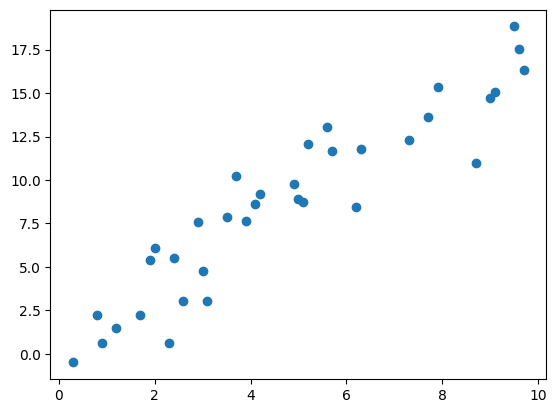

In [4]:
import numpy as np 
import matplotlib.pyplot as plt

X = np.array([2.9,9.5,5.1,0.9,2.0,2.3,5.2,7.7,7.9,4.1,9.7,6.3,4.9,6.2,4.2,
              3.1,3.9,8.7,1.2,9.6,0.8,3.0,5.6,7.3,3.7,3.5,2.6,5.0,1.7,9.1,1.9,2.4,0.3,5.7,9.0])

Y = np.array([7.58,18.83,8.71,0.6,6.06,0.64,12.09,13.65,15.34,8.6,16.32,11.78,9.78,8.44,9.18,
              3.04,7.65,10.96,1.47,17.52,2.21,4.76,13.03,12.29,10.2,7.88,3.01,8.92,2.23,15.08,
              5.42,5.53,-0.5,11.66,14.7])


plt.plot(X, Y, 'o') 

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# declare X and Y datapoints 
X = np.array([2.9,9.5,5.1,0.9,2.0,2.3,5.2,7.7,7.9,4.1,9.7,6.3,4.9,6.2,4.2,
              3.1,3.9,8.7,1.2,9.6,0.8,3.0,5.6,7.3,3.7,3.5,2.6,5.0,1.7,9.1,1.9,2.4,0.3,5.7,9.0])

Y = np.array([7.58,18.83,8.71,0.6,6.06,0.64,12.09,13.65,15.34,8.6,16.32,11.78,9.78,8.44,9.18,
              3.04,7.65,10.96,1.47,17.52,2.21,4.76,13.03,12.29,10.2,7.88,3.01,8.92,2.23,15.08,
              5.42,5.53,-0.5,11.66,14.7])

m, b = 0,1

# generates a random value from a standard normal distribution
# where mean is 0, and standard deviation is 1 
def random_adj(): return np.random.normal(loc=0, scale=1, size=1)[0]

# start best joint likelihood at 0
best_joint_likelihood = 0

# do 10,000 random adjustments to mu and sigma 
for i in range(10_000):

    # randomly adjust mu and sigma 
    m_adj, sigma_adj = random_adj(), random_adj()

    mu += mu_adj
    sigma += sigma_adj

    # calculate the new joint likelihood of all data points 
    new_joint_likelihood = norm.pdf(X, mu, sigma).prod()

    # if joint likelihood improves, keep the changes to mu and sigma 
    if new_joint_likelihood > best_joint_likelihood:
        best_joint_likelihood = new_joint_likelihood
        print(f"mu,sigma -> {mu}, {sigma}")
    else:
        # otherwise undo changes 
        mu -= mu_adj
        sigma -= sigma_adj

# plot the result 
x_range = np.arange(start=-3 * sigma + mu, stop=3 * sigma + mu, step=.01)

plt.plot(X, [0 for _ in X], 'o')
plt.plot(x_range, norm.pdf(x_range, mu, sigma))

plt.show()

m,b,sigma -> 1, 2.5778943899830473, 1
m,b,sigma -> 1.1035266592208568, 2.5778943899830473, 1
m,b,sigma -> 1.1035266592208568, 2.5778943899830473, 1.0559982055107593
m,b,sigma -> 1.1553027416136008, 2.5778943899830473, 1.0559982055107593
m,b,sigma -> 1.1553027416136008, 2.5778943899830473, 2.0035220122319357
m,b,sigma -> 1.282126745603054, 2.5778943899830473, 2.0035220122319357
m,b,sigma -> 1.2821267456030538, 2.5778943899830473, 2.0721633588195507
m,b,sigma -> 1.2821267456030536, 2.5778943899830473, 2.084152918446236
m,b,sigma -> 1.2821267456030534, 2.5778943899830473, 2.2715632397093986
m,b,sigma -> 1.2821267456030534, 2.5778943899830473, 2.2556770089457925
m,b,sigma -> 1.3094729230276179, 2.5778943899830473, 2.2556770089457925
m,b,sigma -> 1.3094729230276179, 2.457670846284961, 2.255677008945793
m,b,sigma -> 1.3094729230276176, 2.457670846284961, 2.1768337706816205
m,b,sigma -> 1.4635837595917098, 2.4576708462849606, 2.176833770681621
m,b,sigma -> 1.4635837595917098, 1.66627634327880

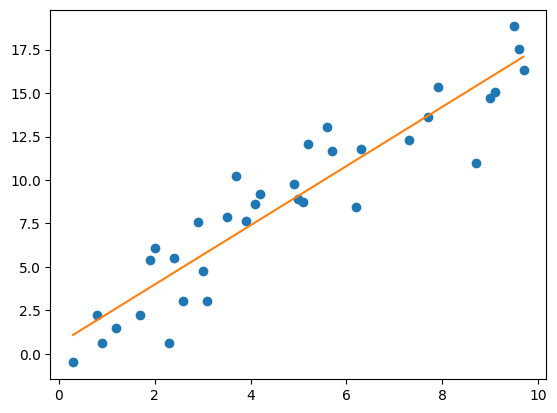

In [21]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# declare X and Y datapoints
X = np.array([2.9,9.5,5.1,0.9,2.0,2.3,5.2,7.7,7.9,4.1,9.7,6.3,4.9,6.2,4.2,
              3.1,3.9,8.7,1.2,9.6,0.8,3.0,5.6,7.3,3.7,3.5,2.6,5.0,1.7,9.1,1.9,2.4,0.3,5.7,9.0])

Y = np.array([7.58,18.83,8.71,0.6,6.06,0.64,12.09,13.65,15.34,8.6,16.32,11.78,9.78,8.44,9.18,
              3.04,7.65,10.96,1.47,17.52,2.21,4.76,13.03,12.29,10.2,7.88,3.01,8.92,2.23,15.08,
              5.42,5.53,-0.5,11.66,14.7])

m, b, sigma = 1,1,1

# generates a random value from a standard normal distribution
# where mean is 0, and standard deviation is 1
def random_adj(): return np.random.normal(loc=0, scale=1, size=1)[0]

# start best joint likelihood at 0
best_joint_likelihood = 0

# do 20,000 random adjustments to mu and sigma
for i in range(20_000):

    # randomly adjust mu and sigma
    rand_adj = random_adj()
    rand_coeff = np.random.randint(0,3)
    if rand_coeff == 0:
        m += rand_adj
    elif rand_coeff == 1:
        b += rand_adj
    elif rand_coeff == 2:
        sigma += rand_adj

    # calculate the new joint likelihood of all data points
    new_joint_likelihood = np.array([norm.pdf(y, m*x+b, sigma) for x,y in zip(X,Y)]).prod()

    # if joint likelihood improves, keep the changes to mu and sigma
    if new_joint_likelihood > best_joint_likelihood:
        best_joint_likelihood = new_joint_likelihood
        print(f"m,b,sigma -> {m}, {b}, {sigma}")
    else:
        # otherwise undo changes
        if rand_coeff == 0:
            m -= rand_adj
        elif rand_coeff == 1:
            b -= rand_adj
        elif rand_coeff == 2:
            sigma -= rand_adj


print(np.linalg.lstsq(np.vstack([X, np.ones(len(X))]).T, Y, rcond=None)[0])

# plot the result
x_range = np.arange(start=X.min(), stop=X.max(), step=.01)

plt.plot(X, Y, 'o')
plt.plot(x_range, m*x_range+b)

plt.show()